In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns


In [3]:
def load_config():
    # Get the absolute path of the project root (one directory up)
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

    # Normalize the project_root to ensure it's correctly formatted
    project_root = os.path.normpath(project_root)
    
    config_path = os.path.join(project_root, 'config.json')

    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found at expected location: {config_path}")

    with open(config_path, 'r') as f:
        config = json.load(f)

    return config, project_root


In [4]:
config, project_root = load_config()

csv_path_enterprise = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["enterprise"]))
csv_path_mobile = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["mobile"]))
csv_path_ics = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["ics"]))
technique_path_enterprise = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_techniques"]["enterprise"]))
technique_path_mobile = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_techniques"]["mobile"]))
technique_path_ics = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_techniques"]["ics"]))

#csv_path_enterprise, csv_path_mobile, csv_path_ics


In [5]:
df_group_enterprise = pd.read_excel(csv_path_enterprise, sheet_name='groups')

# Extract the unique IDs from the first sheet (universe of techniques)
observed_group_ids_enterprise = df_group_enterprise['ID'].unique()
print(len(observed_group_ids_enterprise))


148


In [6]:
df_group_mobile = pd.read_excel(csv_path_mobile, sheet_name='groups')

observed_group_ids_mobile = df_group_mobile['ID'].unique()
print(len(observed_group_ids_mobile))

13


In [7]:
df_group_ics = pd.read_excel(csv_path_ics, sheet_name='groups')

observed_group_ids_ics = df_group_ics['ID'].unique()
print(len(observed_group_ids_ics))

14


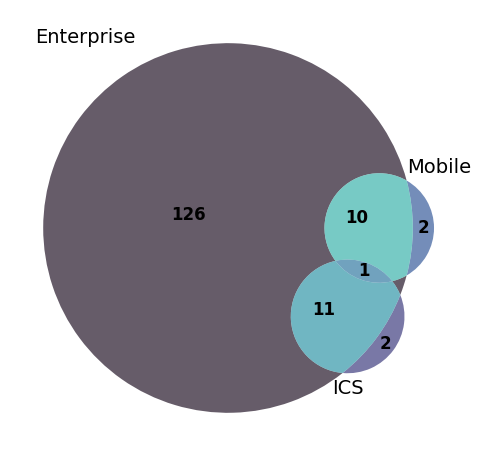

In [8]:
##Ploting group intersection figure across the domains
# Convert lists to sets for easier manipulation
enterprise_set = set(observed_group_ids_enterprise)
mobile_set = set(observed_group_ids_mobile)
ics_set = set(observed_group_ids_ics)

# Create the figure
plt.figure(figsize=(5, 5))

# Create Venn diagram
venn = venn3([enterprise_set, mobile_set, ics_set], ('Enterprise', 'Mobile', 'ICS'))

# Get the mako colormap
cmap = plt.get_cmap('mako')

# Define colors for each of the 7 Venn subsets (7 = 2^3 - 1)
# We pick colors spaced evenly from the colormap
colors = [cmap(x) for x in [0.1, 0.4, 0.7, 0.3, 0.6, 0.8, 0.5]]

# Apply colors to each patch if it exists
for patch, color in zip(venn.patches, colors):
    if patch:  # patch can be None if the subset is empty
        patch.set_facecolor(color)
        patch.set_alpha(0.7)  # Adjust transparency if you like

# Bold and increase font size for set labels
for label in venn.set_labels:
    label.set_fontsize(14)
    #label.set_fontweight('bold')

# Bold and increase font size for subset labels (numbers)
for subset_label in venn.subset_labels:
    if subset_label:
        subset_label.set_fontsize(12)
        subset_label.set_fontweight('bold')

plt.tight_layout()

# Optional title and save
# plt.title("Venn Diagram of Group IDs across Enterprise, Mobile, and ICS", fontsize=16)
#plt.savefig("figure/venn_diagram_groups.pdf", format='pdf')

#plt.show()

In [9]:
# Find techniques that are in all three sets (intersection)
groups_in_all_three = enterprise_set & mobile_set & ics_set

# Find techniques that are only in mobile (difference with enterprise and ICS)
groups_only_in_mobile = mobile_set - (enterprise_set | ics_set)

# Find techniques that are only in ICS (difference with enterprise and mobile)
groups_only_in_ics = ics_set - (enterprise_set | mobile_set)

# Output the results
print("Groups in all three categories (Enterprise, Mobile, ICS):")
print(groups_in_all_three)

print("Groups only in Mobile (not in Enterprise or ICS):")
print(groups_only_in_mobile)

print("Groups only in ICS (not in Enterprise or Mobile):")
print(groups_only_in_ics)


Groups in all three categories (Enterprise, Mobile, ICS):
{'G0034'}
Groups only in Mobile (not in Enterprise or ICS):
{'G0097', 'G1029'}
Groups only in ICS (not in Enterprise or Mobile):
{'G1000', 'G1027'}


In [10]:
# Helper function to load 'techniques in all the domains' data
def load_techniques(file_path):
    df = pd.read_excel(file_path, sheet_name='techniques')
    return df[['ID', 'name']]

dfs = [load_techniques(f) for f in [technique_path_enterprise, technique_path_mobile, technique_path_ics]]
all_techniques = pd.concat(dfs, ignore_index =True)


In [11]:
len(all_techniques)

839

In [12]:
# Extract unique technique IDs
technique_ids = all_techniques['ID'].unique()

# Split into main and sub-technique categories
main_techniques = set()
sub_technique_parents = set()

for tid in technique_ids:
    if '.' in tid:
        parent_id = tid.split('.')[0]
        sub_technique_parents.add(parent_id)
    else:
        main_techniques.add(tid)

# Techniques without any sub-techniques
main_techniques_without_subs = main_techniques - sub_technique_parents

# Optional: get their names too
techniques_without_subs_df = all_techniques[all_techniques['ID'].isin(main_techniques_without_subs)]

# Print summary
print(f"Total top-level techniques: {len(main_techniques)}")
print(f"Top-level techniques WITH sub-techniques: {len(sub_technique_parents)}")
print(f"Top-level techniques WITHOUT sub-techniques: {len(main_techniques_without_subs)}")

Total top-level techniques: 358
Top-level techniques WITH sub-techniques: 121
Top-level techniques WITHOUT sub-techniques: 237


In [30]:
# Helper function to load 'techniques used by group in all the domains' data
def load_techniques_used_group(file_path):
    df = pd.read_excel(file_path, sheet_name='techniques used')
    return df[['source ID', 'target ID', 'target name']]

# Combine all domains
dfs = [load_techniques_used_group(f) for f in [csv_path_enterprise, csv_path_mobile, csv_path_ics]]
combined_df = pd.concat(dfs, ignore_index=True)

In [31]:
group_to_techniques = combined_df.groupby('source ID')['target ID'].apply(set)

In [48]:
#len(group_to_techniques) 
len(combined_df)

3433

In [35]:
# Calculate observed and unobserved techniques
observed_ids = combined_df['target ID'].unique()
unobserved_techniques = all_techniques[~all_techniques['ID'].isin(observed_ids)]

# Stats
total_techniques = len(all_techniques)
observed_techniques = len(observed_ids)
unobserved_count = len(unobserved_techniques)
unique_groups = combined_df['source ID'].nunique()

# Output statistics
print(f"Total techniques reported by MITRE: {total_techniques}")
print(f"Total techniques observed across all domains among groups: {observed_techniques}")
print(f"Techniques not observed in any domain: {unobserved_count}")
print(f"Total unique groups: {unique_groups}")

# Display sample group-to-techniques mapping
print("\nSample group techniques mapping:")
sample_groups = combined_df['source ID'].dropna().unique()[:3]
for group_id in sample_groups:
    techniques = combined_df[combined_df['source ID'] == group_id]['target ID'].unique()
    print(f"\nGroup ID: {group_id}")
    print(f"Techniques used ({len(techniques)}): {list(techniques)}")

Total techniques reported by MITRE: 839
Total techniques observed across all domains among groups: 451
Techniques not observed in any domain: 388
Total unique groups: 148

Sample group techniques mapping:

Group ID: G0099
Techniques used (9): ['T1105', 'T1204.002', 'T1036.004', 'T1571', 'T1027', 'T1053.005', 'T1566.001', 'T1588.002', 'T1059.005']

Group ID: G0006
Techniques used (23): ['T1560.001', 'T1119', 'T1005', 'T1583.001', 'T1584.001', 'T1585.002', 'T1003.001', 'T1087.001', 'T1114.001', 'T1588.001', 'T1036.005', 'T1135', 'T1550.002', 'T1057', 'T1021.001', 'T1114.002', 'T1566.001', 'T1566.002', 'T1016', 'T1049', 'T1007', 'T1588.002', 'T1059.003']

Group ID: G0005
Techniques used (5): ['T1102.002', 'T1568.003', 'T1203', 'T1204.002', 'T1566.001']


In [40]:
# Build binary group-technique matrix

group_tech_matrix = pd.crosstab(combined_df['source ID'], combined_df['target ID'])
binary_matrix = group_tech_matrix.astype(bool).astype(int)

# Count how many groups use each technique
tech_counts = binary_matrix.sum(axis=0)

# Compute co-occurrence rate (intersection / max counts)
intersection = binary_matrix.T.dot(binary_matrix)
denominator = np.maximum(tech_counts.values[:, None], tech_counts.values[None, :])
jaccard_matrix = intersection / denominator
np.fill_diagonal(jaccard_matrix.values, 0)

# Set threshold
threshold = 0.5
jaccard_filtered = jaccard_matrix.where(jaccard_matrix >= threshold)
jaccard_filtered = jaccard_filtered.dropna(how='all', axis=0).dropna(how='all', axis=1)

# Optional: build mapping from technique ID to name
id_to_name = combined_df[['target ID', 'target name']].drop_duplicates().set_index('target ID')['target name'].to_dict()

# Extract top technique pairs
tech_ids = jaccard_matrix.index.tolist()
top_pairs = []
for i in range(len(tech_ids)):
    for j in range(i + 1, len(tech_ids)):
        score = jaccard_matrix.iloc[i, j]
        if score >= threshold:
            t1 = tech_ids[i]
            t2 = tech_ids[j]
            top_pairs.append((t1, t2, id_to_name.get(t1, ""), id_to_name.get(t2, ""), score))

# Sort by similarity score
top_pairs_sorted = sorted(top_pairs, key=lambda x: x[4], reverse=True)

# Print top N
top_n = 10
# Show technique pairs with Jaccard similarity < 1.0 but ≥ 0.6
print(f"\n Technique pairs with Jaccard similarity between 0.6 and < 1.0:\n")

for t1, t2, name1, name2, score in top_pairs_sorted:
    if 0.6 <= score < 1 :
        print(f"{t1} ({name1}) - {t2} ({name2}): {score:.3f}")


# Optional: Save to CSV
# pd.DataFrame(top_pairs_sorted, columns=["Technique A", "Technique B", "Name A", "Name B", "Jaccard Score"]).to_csv("top_technique_pairs.csv", index=False)



 Technique pairs with Jaccard similarity between 0.6 and < 1.0:

T1204.001 (Malicious Link) - T1566.002 (Spearphishing Link): 0.951
T1204.002 (Malicious File) - T1566.001 (Spearphishing Attachment): 0.886
T1059.004 (Unix Shell) - T1496 (Resource Hijacking): 0.750
T1529 (System Shutdown/Reboot) - T1561.002 (Disk Structure Wipe): 0.750
T1589.003 (Employee Names) - T1594 (Search Victim-Owned Websites): 0.750
T1003.003 (NTDS) - T1087.002 (Domain Account): 0.684
T1105 (Ingress Tool Transfer) - T1204.002 (Malicious File): 0.671
T1021.007 (Cloud Services) - T1621 (Multi-Factor Authentication Request Generation): 0.667
T1027.004 (Compile After Delivery) - T1559.001 (Component Object Model): 0.667
T1059.004 (Unix Shell) - T1070.002 (Clear Linux or Mac System Logs): 0.667
T1059.004 (Unix Shell) - T1071 (Application Layer Protocol): 0.667
T1059.004 (Unix Shell) - T1222.002 (Linux and Mac File and Directory Permissions Modification): 0.667
T1059.004 (Unix Shell) - T1543.002 (Systemd Service): 0.6

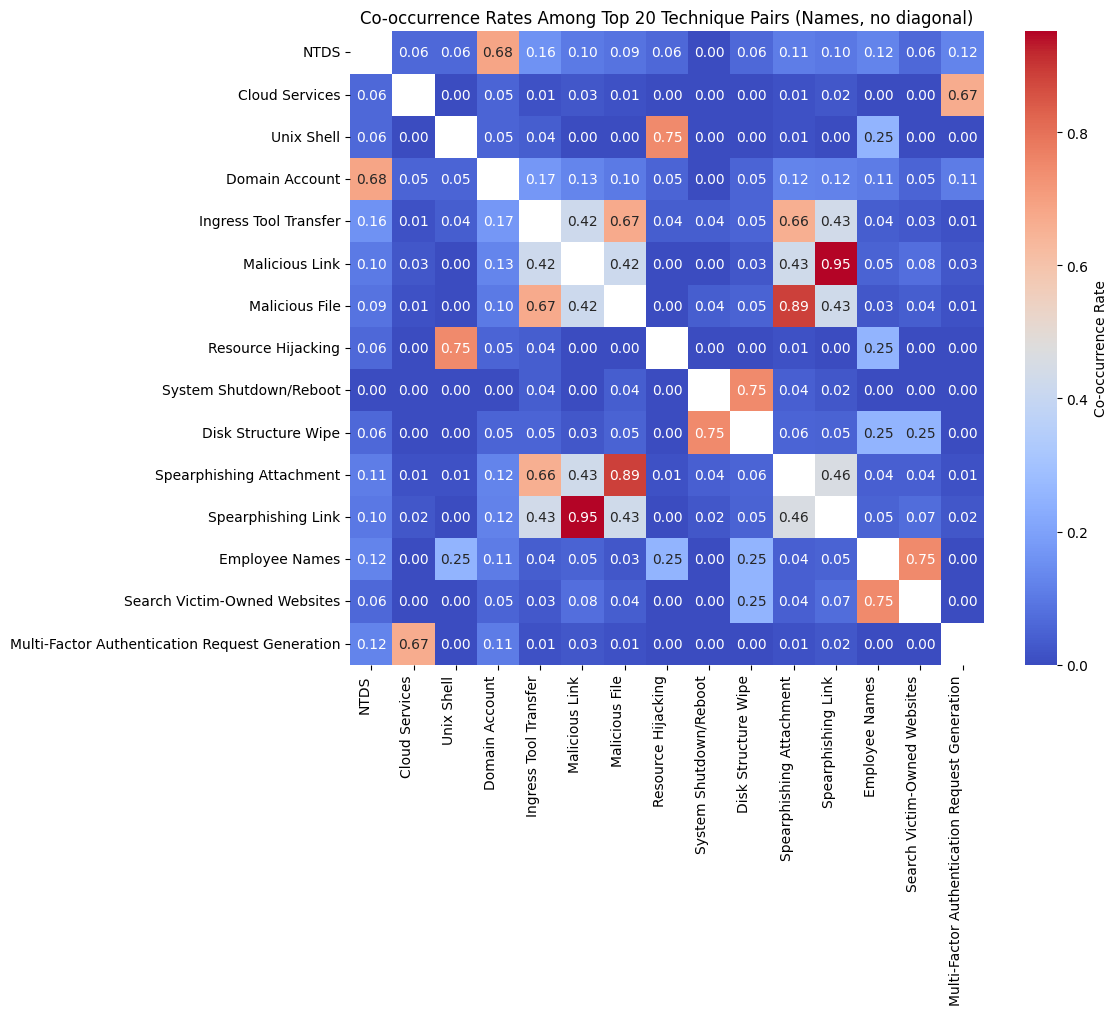

In [49]:
# Filter pairs with 0.6 <= score < 1.0
filtered_pairs = [(t1, t2, name1, name2, score) for t1, t2, name1, name2, score in top_pairs_sorted if 0.6 <= score < 1.0]

# Take top 20 pairs from filtered
top_20_pairs = filtered_pairs[:8]

# Extract unique technique IDs from top pairs
technique_ids = set()
for t1, t2, _, _, _ in top_20_pairs:
    technique_ids.add(t1)
    technique_ids.add(t2)
technique_ids = sorted(technique_ids)

# Map IDs to names for labels
technique_names = [id_to_name.get(tid, tid) for tid in technique_ids]

# Create empty DataFrame with technique IDs as index/columns for data filling
heatmap_df = pd.DataFrame(index=technique_ids, columns=technique_ids, dtype=float)

# Fill in the data as before
for i in range(len(technique_ids)):
    for j in range(len(technique_ids)):
        if i == j:
            heatmap_df.iat[i, j] = np.nan  # blank diagonal
        else:
            t1 = technique_ids[i]
            t2 = technique_ids[j]
            heatmap_df.iat[i, j] = jaccard_matrix.at[t1, t2] if (t1 in jaccard_matrix.index and t2 in jaccard_matrix.columns) else np.nan

# Now update index and columns to technique names (for display only)
heatmap_df.index = technique_names
heatmap_df.columns = technique_names

# Plot heatmap with technique names
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Co-occurrence Rate'}, square=True)
plt.title("Co-occurrence Rates Among Top 20 Technique Pairs (Names, no diagonal)")
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
